In [2]:
import os
import sys
import seaborn as sns
import matplotlib.pyplot as plt
from sharp import ShaRP

sys.path.append("..")

from itertools import product
from lightgbm import LGBMRanker
from sklearn.utils import check_random_state
from xai_ranking.benchmarks import (
    human_in_the_loop_experiment,
    human_in_the_loop_batch_experiment,
    hierarchical_ranking_explanation,
    hierarchical_ranking_batch_explanation,
    lime_experiment,
    lime_batch_experiment,
    shap_experiment,
    shap_batch_experiment,
    sharp_experiment,
    sharp_batch_experiment,
    # participation_experiment,
)
from xai_ranking.preprocessing import (
    preprocess_atp_data,
    preprocess_csrank_data,
    preprocess_higher_education_data,
    preprocess_movers_data,
    preprocess_synthetic_data,
)
from xai_ranking.datasets import (
    fetch_atp_data,
    fetch_csrank_data,
    fetch_higher_education_data,
    fetch_movers_data,
    fetch_synthetic_data,
)
from xai_ranking.scorers import (
    atp_score,
    csrank_score,
    higher_education_score,
    synthetic_equal_score_3ftrs,
)
from xai_ranking.metrics import (
    cross_method_explanation_consistency
)
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from mlresearch.utils import check_random_states, set_matplotlib_style
from sharp.utils import scores_to_ordering

RNG_SEED = 42

In [40]:
import matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
set_matplotlib_style(font_size=24, use_latex=True, **{'font.family': 'Times New Roman'})


In [4]:
datasets = [
    {
        "name": "Higher Education",
        "data": preprocess_higher_education_data(
            fetch_higher_education_data(year=2020)
        ),
        "scorer": higher_education_score,
        "n_observations": 100,
    },
    {
        "name": "ATP",
        "data": preprocess_atp_data(fetch_atp_data()),
        "scorer": atp_score,
        "n_observations": 86,
    },
    {
        "name": "CSRank",
        "data": preprocess_csrank_data(fetch_csrank_data()),
        "scorer": csrank_score,
        "n_observations": 100,
    },
    {
        "name": "Synthetic_0",
        "data": preprocess_synthetic_data(
            fetch_synthetic_data(synth_dt_version=0, item_num=2000)
        ),
        "scorer": synthetic_equal_score_3ftrs,
        "n_observations": 100,
    },
    {
        "name": "Synthetic_1",
        "data": preprocess_synthetic_data(
            fetch_synthetic_data(synth_dt_version=1, item_num=2000)
        ),
        "scorer": synthetic_equal_score_3ftrs,
        "n_observations": 100,
    },
    {
        "name": "Synthetic_2",
        "data": preprocess_synthetic_data(
            fetch_synthetic_data(synth_dt_version=2, item_num=2000)
        ),
        "scorer": synthetic_equal_score_3ftrs,
        "n_observations": 100,
    },
]

xai_methods = [
    {
        "iterations": 1,
        "name": "LIME",
        "experiment": lime_experiment,
        "type": "score",
        "kwargs": {"mode": "regression"},  # classification, regression
    },
    {
        "iterations": 1,
        "name": "SHAP",
        "experiment": shap_experiment,
        "type": "score",
        "kwargs": {},
    },
    {
        "iterations": 1,
        "name": "ShaRP_RANK",
        "experiment": sharp_experiment,
        "type": "rank",
        "kwargs": {
            "qoi": "rank",
            "verbose": True,
            "sample_size": None,
            "measure": "shapley",
            "n_jobs": -1,
            "replace": False,
        },
    },
    {
        "iterations": 1,
        "name": "ShaRP_SCORE",
        "experiment": sharp_experiment,
        "type": "score",
        "kwargs": {
            "qoi": "rank_score",
            "verbose": True,
            "sample_size": None,
            "measure": "shapley",
            "n_jobs": -1,
            "replace": False,
        },
    },
    # {
    #     "iterations": 1,
    #     "name": "ShaRP_TOPK",
    #     "experiment": sharp_experiment,
    #     "kwargs": {
    #         "qoi": "top_k",
    #         "verbose": True,
    #         "sample_size": None,
    #         "measure": "shapley",
    #         "n_jobs": -1,
    #         "replace": True,
    #     },
    # },
    {
        "iterations": 1,
        "name": "HRE_DT",
        "type": "score",
        "experiment": hierarchical_ranking_explanation,
        "kwargs": {"model_type": "DT", "s": 10},  # DT, LR, OLS, PLS
    },
    {
        "iterations": 1,
        "name": "HRE_LR",
        "type": "score",
        "experiment": hierarchical_ranking_explanation,
        "kwargs": {"model_type": "LR", "s": 10},  # DT, LR, OLS, PLS
    },
    {
        "iterations": 1,
        "name": "HRE_OLS",
        "type": "score",
        "experiment": hierarchical_ranking_explanation,
        "kwargs": {"model_type": "OLS", "s": 10},  # DT, LR, OLS, PLS
    },
    {
        "iterations": 1,
        "name": "HRE_PLS",
        "type": "score",
        "experiment": hierarchical_ranking_explanation,
        "kwargs": {"model_type": "PLS", "s": 10},  # DT, LR, OLS, PLS
    },
    # {
    #     "iterations": 1,
    #     "name": "HIL_Shapley",
    #     "experiment": human_in_the_loop_experiment,
    #     "kwargs": {"upper_bound": 1, "lower_bound": None, "method_type": "shapley"},
    # },
    {
        "iterations": 1,
        "name": "HIL_Standardized-Shapley",
        "type": "std-score",
        "experiment": human_in_the_loop_experiment,
        "kwargs": {
            "upper_bound": 1,
            "lower_bound": None,
            "method_type": "standardized shapley",
        },
    },
    {
        "iterations": 1,
        "name": "HIL_Rank-Shapley",
        "experiment": human_in_the_loop_experiment,
        "type": "std-rank",
        "kwargs": {
            "upper_bound": 1,
            "lower_bound": None,
            "method_type": "rank-relevance shapley",
        },
    },
    # {
    #     "iterations": 1,
    #     "name": "RankLIME",
    #     "experiment": rank_lime_experiment,
    #     "kwargs": {
    #         "explanation_size": 3,
    #         "rank_similarity_coefficient": lambda x, y: kendalltau(x, y)[0],
    #         "individual_masking": True,
    #         "use_entry": 0,
    #         "use_pandas_where": False,
    #     },
    # },
    # {"iterations": 1, "name": "Participation", "experiment": participation_experiment},
]


In [5]:
def read_results_from_files():
    return_dict = {}
    for cur_dataset in datasets:
        return_dict[cur_dataset["name"]] = {}
        for cur_xai_method in xai_methods:
            return_dict[cur_dataset["name"]][cur_xai_method["name"]] = []
            for iteration in range(cur_xai_method["iterations"]):
                fname = (
                    f"results/contributions/_contributions_"
                    f"{cur_dataset['name']}_{cur_xai_method['name']}_"
                    f"{iteration}.csv"
                )
                if os.path.isfile(fname):
                    (
                        return_dict[cur_dataset["name"]][cur_xai_method["name"]].append(
                            pd.read_csv(fname, index_col=0)
                        )
                    )
    return return_dict

In [6]:
results = read_results_from_files()

In [7]:
# results

In [15]:
methods_mapper = {
    "HIL Standardized-Shapley": "HIL Score",
    "HIL Rank-Shapley": "HIL Rank",
    "ShaRP RANK": "ShaRP Rank",
    "ShaRP SCORE": "ShaRP Score",
}

In [28]:
datasets_mapper = {
    "Higher Education": "THE",
    "CSRank": "CSR",
    "Synthetic 0": "Syn 0",
    "Synthetic 1": "Syn 1",
    "Synthetic 2": "Syn 2",
}

# Explanation Agreement across methods
## Jaccard top-2

In [8]:
agreement_sharp_datasets_rank = []
agreement_sharp_datasets_score = []
agreement_methods_methods = []

In [9]:
methods = [method for method in results["ATP"].keys() if not method.startswith("BATCH")]

exp_cons_res = {}
exp_cons_sem = {}
for dataset in datasets:
    exp_cons_res[dataset["name"]] = pd.DataFrame(index=methods, columns=methods)
    exp_cons_sem[dataset["name"]] = pd.DataFrame(index=methods, columns=methods)
    for method1, method2 in product(methods, methods):
        result = cross_method_explanation_consistency(
            results[dataset["name"]][method1][0],
            results[dataset["name"]][method2][0],
            measure="jaccard",
            n_features=2,
        )

        exp_cons_res[dataset["name"]].loc[method1, method2] = result[0]
        exp_cons_sem[dataset["name"]].loc[method1, method2] = result[1]

KeyboardInterrupt: 

In [80]:
avg_exp_cons_res = pd.DataFrame(columns=methods, index=methods).fillna(0)
for dataset, res_ in exp_cons_res.items():
    avg_exp_cons_res += res_

avg_exp_cons_res /= len(datasets)
avg_exp_cons_res

/tmp/ipykernel_812748/417100189.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  avg_exp_cons_res = pd.DataFrame(columns=methods, index=methods).fillna(0)


,LIME,SHAP,ShaRP_RANK,ShaRP_SCORE,HRE_DT,HRE_LR,HRE_OLS,HRE_PLS,HIL_Standardized-Shapley,HIL_Rank-Shapley
LIME,1.0,0.75741,0.748132,0.756347,0.501754,0.467938,0.513879,0.45964,0.509049,0.508572
SHAP,0.75741,1.0,0.832838,0.926829,0.497875,0.477494,0.50436,0.485906,0.484412,0.483991
ShaRP_RANK,0.748132,0.832838,1.0,0.868196,0.500548,0.468955,0.50942,0.478314,0.511245,0.510824
ShaRP_SCORE,0.756347,0.926829,0.868196,1.0,0.495549,0.476802,0.50378,0.483856,0.487379,0.486957
HRE_DT,0.501754,0.497875,0.500548,0.495549,1.0,0.521905,0.482018,0.528806,0.500412,0.501842
HRE_LR,0.467938,0.477494,0.468955,0.476802,0.521905,1.0,0.473784,0.444919,0.453569,0.456206
HRE_OLS,0.513879,0.50436,0.50942,0.50378,0.482018,0.473784,1.0,0.406475,0.513396,0.515387
HRE_PLS,0.45964,0.485906,0.478314,0.483856,0.528806,0.444919,0.406475,1.0,0.443107,0.445864
HIL_Standardized-Shapley,0.509049,0.484412,0.511245,0.487379,0.500412,0.453569,0.513396,0.443107,1.0,0.998628
HIL_Rank-Shapley,0.508572,0.483991,0.510824,0.486957,0.501842,0.456206,0.515387,0.445864,0.998628,1.0


In [1]:
avg_exp_cons_res = pd.DataFrame(columns=methods, index=methods).fillna(0)
for dataset, res in exp_cons_res.items():
    temp = res / len(datasets)
    avg_exp_cons_res += temp.fillna(0)

avg_exp_cons_res
avg_exp_cons_res.columns = avg_exp_cons_res.columns.str.replace('_', ' ')
avg_exp_cons_res.index = avg_exp_cons_res.index.str.replace('_', ' ')
# sns.set(font_scale=2)  # crazy big
sns.heatmap(avg_exp_cons_res.astype('float'), mask=avg_exp_cons_res.isnull(),vmin=0, vmax=1, cmap="Reds")

agreement_methods_methods.append(avg_exp_cons_res.astype('float'))

plt.savefig(
    "results/agreement/agreement-jaccard2-all_methods.pdf",
    format="pdf",
    bbox_inches="tight",
    transparent=True
)

plt.show()

NameError: name 'pd' is not defined

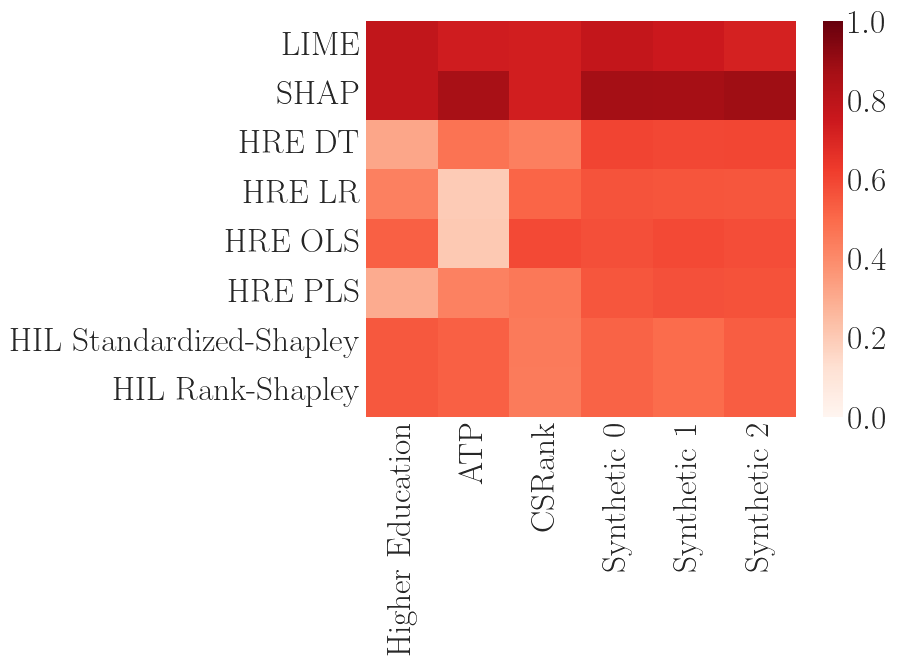

In [82]:
df = pd.DataFrame()
for dataset in datasets:
    df[dataset["name"]] = pd.to_numeric(exp_cons_res[dataset["name"]]["ShaRP_RANK"], downcast="float")

df.drop(["ShaRP_RANK", "ShaRP_SCORE"],inplace=True)
df.columns = df.columns.str.replace('_', ' ')
df.index = df.index.str.replace('_', ' ')

# sns.set(font_scale=2)  # crazy big
sns.heatmap(df, mask=df.isnull(),vmin=0, vmax=1, cmap="Reds")

agreement_sharp_datasets_rank.append(df.copy())

plt.savefig(
"results/agreement/agreement-jaccard2-sharp-rank.pdf",
format="pdf",
bbox_inches="tight",
transparent=True
)

plt.show()

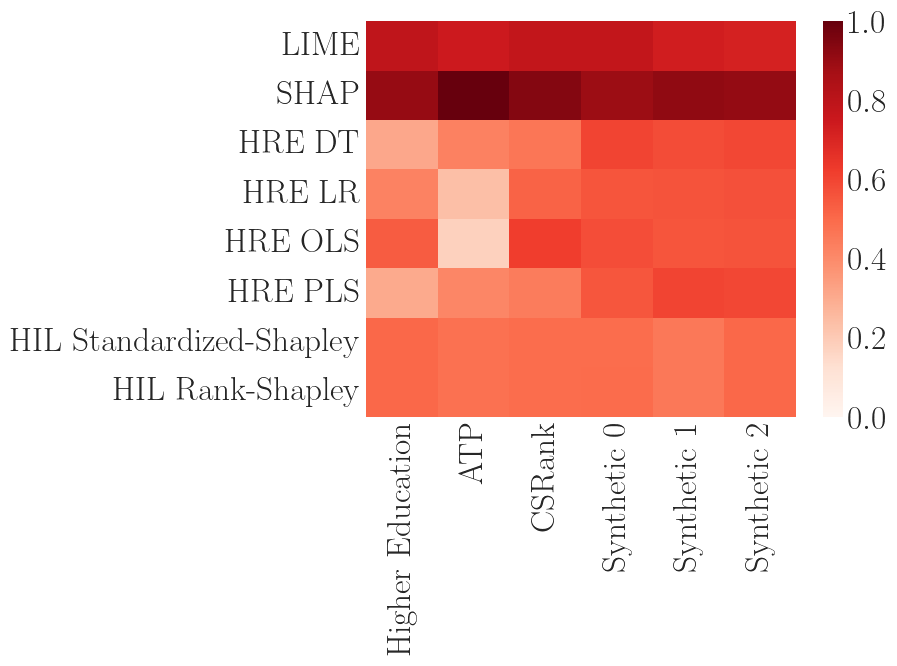

In [83]:
df = pd.DataFrame()
for dataset in datasets:
    df[dataset["name"]] = pd.to_numeric(exp_cons_res[dataset["name"]]["ShaRP_SCORE"], downcast="float")

df.drop(["ShaRP_RANK", "ShaRP_SCORE"],inplace=True)
df.columns = df.columns.str.replace('_', ' ')
df.index = df.index.str.replace('_', ' ')

# sns.set(font_scale=2)  # crazy big
sns.heatmap(df, mask=df.isnull(),vmin=0, vmax=1, cmap="Reds")

agreement_sharp_datasets_score.append(df.copy())

plt.savefig(
"results/agreement/agreement-jaccard2-sharp-score.pdf",
format="pdf",
bbox_inches="tight",
transparent=True
)

plt.show()

## Kendall

In [10]:
methods = [method for method in results["ATP"].keys() if not method.startswith("BATCH")]

exp_cons_res_ken = {}
exp_cons_sem_ken = {}
for dataset in datasets:
    exp_cons_res_ken[dataset["name"]] = pd.DataFrame(index=methods, columns=methods)
    exp_cons_sem_ken[dataset["name"]] = pd.DataFrame(index=methods, columns=methods)
    for method1, method2 in product(methods, methods):
        result = cross_method_explanation_consistency(
            results[dataset["name"]][method1][0],
            results[dataset["name"]][method2][0],
            measure="kendall"
        )

        exp_cons_res_ken[dataset["name"]].loc[method1, method2] = result[0]
        exp_cons_sem_ken[dataset["name"]].loc[method1, method2] = result[1]

In [12]:
avg_exp_cons_res_ken = pd.DataFrame(columns=methods, index=methods).fillna(0)
for dataset, res_ in exp_cons_res_ken.items():
    avg_exp_cons_res_ken += res_

avg_exp_cons_res_ken /= len(datasets)
avg_exp_cons_res_ken

/tmp/ipykernel_947707/2812128093.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  avg_exp_cons_res_ken = pd.DataFrame(columns=methods, index=methods).fillna(0)


,LIME,SHAP,ShaRP_RANK,ShaRP_SCORE,HRE_DT,HRE_LR,HRE_OLS,HRE_PLS,HIL_Standardized-Shapley,HIL_Rank-Shapley
LIME,1.0,0.885084,0.882575,0.886964,0.572322,0.494484,0.490992,0.510166,0.689773,0.691532
SHAP,0.885084,1.0,0.926165,0.961759,0.575667,0.490368,0.47399,0.505948,0.71628,0.718213
ShaRP_RANK,0.882575,0.926165,1.0,0.948625,0.577523,0.508938,0.514437,0.514622,0.753949,0.755865
ShaRP_SCORE,0.886964,0.961759,0.948625,1.0,0.574063,0.493747,0.485607,0.50632,0.72005,0.721984
HRE_DT,0.572322,0.575667,0.577523,0.574063,1.0,0.609304,0.588141,0.592903,0.579113,0.580009
HRE_LR,0.494484,0.490368,0.508938,0.493747,0.609304,1.0,0.6027,0.522158,0.583417,0.584682
HRE_OLS,0.490992,0.47399,0.514437,0.485607,0.588141,0.6027,1.0,0.476323,0.62375,0.625004
HRE_PLS,0.510166,0.505948,0.514622,0.50632,0.592903,0.522158,0.476323,1.0,0.536841,0.538153
HIL_Standardized-Shapley,0.689773,0.71628,0.753949,0.72005,0.579113,0.583417,0.62375,0.536841,1.0,1.0
HIL_Rank-Shapley,0.691532,0.718213,0.755865,0.721984,0.580009,0.584682,0.625004,0.538153,1.0,1.0


/tmp/ipykernel_947707/917110336.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  avg_exp_cons_res_ken = pd.DataFrame(columns=methods, index=methods).fillna(0)
/tmp/ipykernel_947707/917110336.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  avg_exp_cons_res_ken += temp.fillna(0)


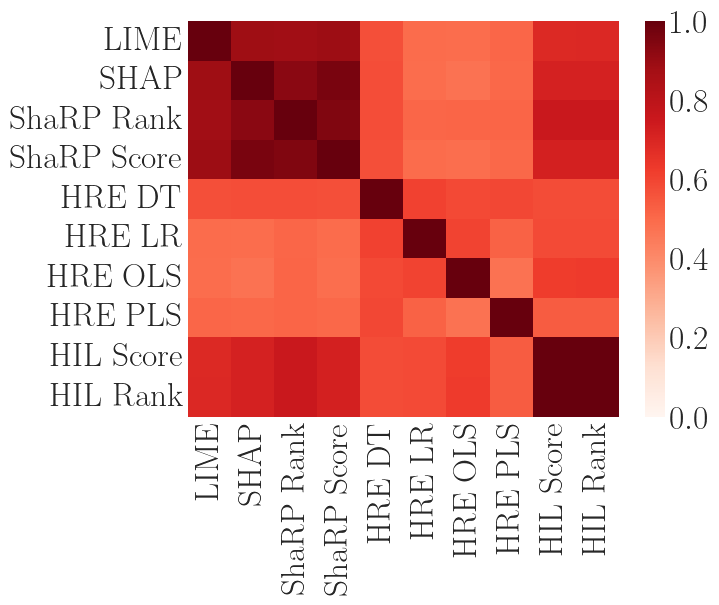

In [41]:
avg_exp_cons_res_ken = pd.DataFrame(columns=methods, index=methods).fillna(0)
for dataset, res in exp_cons_res_ken.items():
    temp = res / len(datasets)
    avg_exp_cons_res_ken += temp.fillna(0)

# avg_exp_cons_res_ken
avg_exp_cons_res_ken.columns = avg_exp_cons_res_ken.columns.str.replace('_', ' ')
avg_exp_cons_res_ken.index = avg_exp_cons_res_ken.index.str.replace('_', ' ')

avg_exp_cons_res_ken = avg_exp_cons_res_ken.rename(methods_mapper).rename(columns=methods_mapper)
# sns.set(font_scale=2)  # crazy big
sns.heatmap(avg_exp_cons_res_ken.astype('float'), mask=avg_exp_cons_res_ken.isnull(),vmin=0, vmax=1, cmap="Reds")


agreement_methods_methods.append(avg_exp_cons_res_ken.astype('float'))

plt.savefig(
"results/agreement/agreement-kendall-all_methods.pdf",
format="pdf",
bbox_inches="tight",
transparent=True
)

plt.show()

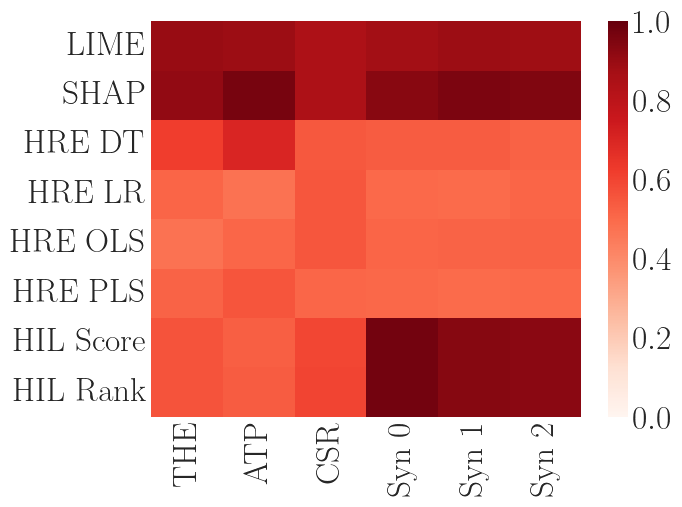

In [42]:
df = pd.DataFrame()
for dataset in datasets:
    df[dataset["name"]] = pd.to_numeric(exp_cons_res_ken[dataset["name"]]["ShaRP_RANK"], downcast="float")

df.drop(["ShaRP_RANK", "ShaRP_SCORE"],inplace=True)
df.columns = df.columns.str.replace('_', ' ')
df.index = df.index.str.replace('_', ' ')

df = df.rename(methods_mapper).rename(columns=datasets_mapper)

# sns.set(font_scale=2)  # crazy big
sns.heatmap(df, mask=df.isnull(),vmin=0, vmax=1, cmap="Reds")

agreement_sharp_datasets_rank.append(df.copy())

plt.savefig(
"results/agreement/agreement-kendall-sharp-rank.pdf",
format="pdf",
bbox_inches="tight",
transparent=True
)

plt.show()

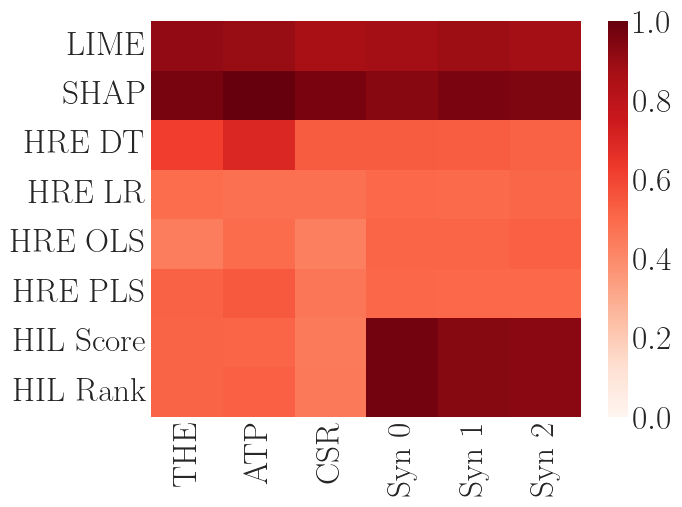

In [43]:
df = pd.DataFrame()
for dataset in datasets:
    df[dataset["name"]] = pd.to_numeric(exp_cons_res_ken[dataset["name"]]["ShaRP_SCORE"], downcast="float")

df.drop(["ShaRP_RANK", "ShaRP_SCORE"],inplace=True)
df.columns = df.columns.str.replace('_', ' ')
df.index = df.index.str.replace('_', ' ')

df = df.rename(methods_mapper).rename(columns=datasets_mapper)

sns.heatmap(df, mask=df.isnull(),vmin=0, vmax=1, cmap="Reds")

agreement_sharp_datasets_score.append(df.copy())

plt.savefig(
"results/agreement/agreement-kendall-sharp-score.pdf",
format="pdf",
bbox_inches="tight",
transparent=True
)

plt.show()

## Euclidean normalized

In [89]:
methods = [method for method in results["ATP"].keys() if not method.startswith("BATCH")]

exp_cons_res_euc = {}
exp_cons_sem_euc = {}
for dataset in datasets:
    exp_cons_res_euc[dataset["name"]] = pd.DataFrame(index=methods, columns=methods)
    exp_cons_sem_euc[dataset["name"]] = pd.DataFrame(index=methods, columns=methods)
    for method1, method2 in product(methods, methods):
        result = cross_method_explanation_consistency(
            results[dataset["name"]][method1][0],
            results[dataset["name"]][method2][0],
            measure="euclidean",
            normalization=True
        )

        exp_cons_res_euc[dataset["name"]].loc[method1, method2] = result[0]
        exp_cons_sem_euc[dataset["name"]].loc[method1, method2] = result[1]

In [90]:
avg_exp_cons_res_euc = pd.DataFrame(columns=methods, index=methods).fillna(0)
for dataset, res_ in exp_cons_res_euc.items():
    avg_exp_cons_res_euc += res_

avg_exp_cons_res_euc /= len(datasets)
avg_exp_cons_res_euc

/tmp/ipykernel_812748/3780719201.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  avg_exp_cons_res_euc = pd.DataFrame(columns=methods, index=methods).fillna(0)


,LIME,SHAP,ShaRP_RANK,ShaRP_SCORE,HRE_DT,HRE_LR,HRE_OLS,HRE_PLS,HIL_Standardized-Shapley,HIL_Rank-Shapley
LIME,1.0,0.850382,0.83633,0.859602,0.313464,0.311354,0.317697,0.313484,0.374988,0.376398
SHAP,0.850382,1.0,0.884604,0.947945,0.303048,0.292341,0.296841,0.297816,0.359459,0.360867
ShaRP_RANK,0.83633,0.884604,1.0,0.910969,0.336158,0.340083,0.348694,0.3436,0.41072,0.412111
ShaRP_SCORE,0.859602,0.947945,0.910969,1.0,0.30804,0.300586,0.306376,0.305668,0.370519,0.371934
HRE_DT,0.313464,0.303048,0.336158,0.30804,1.0,0.605372,0.590581,0.612801,0.593897,0.594094
HRE_LR,0.311354,0.292341,0.340083,0.300586,0.605372,1.0,0.89571,0.811632,0.795174,0.794764
HRE_OLS,0.317697,0.296841,0.348694,0.306376,0.590581,0.89571,1.0,0.767225,0.80561,0.805277
HRE_PLS,0.313484,0.297816,0.3436,0.305668,0.612801,0.811632,0.767225,1.0,0.749114,0.748721
HIL_Standardized-Shapley,0.374988,0.359459,0.41072,0.370519,0.593897,0.795174,0.80561,0.749114,1.0,0.998405
HIL_Rank-Shapley,0.376398,0.360867,0.412111,0.371934,0.594094,0.794764,0.805277,0.748721,0.998405,1.0


/tmp/ipykernel_812748/4158016421.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  avg_exp_cons_res_euc = pd.DataFrame(columns=methods, index=methods).fillna(0)
/tmp/ipykernel_812748/4158016421.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  avg_exp_cons_res_euc += temp.fillna(0)


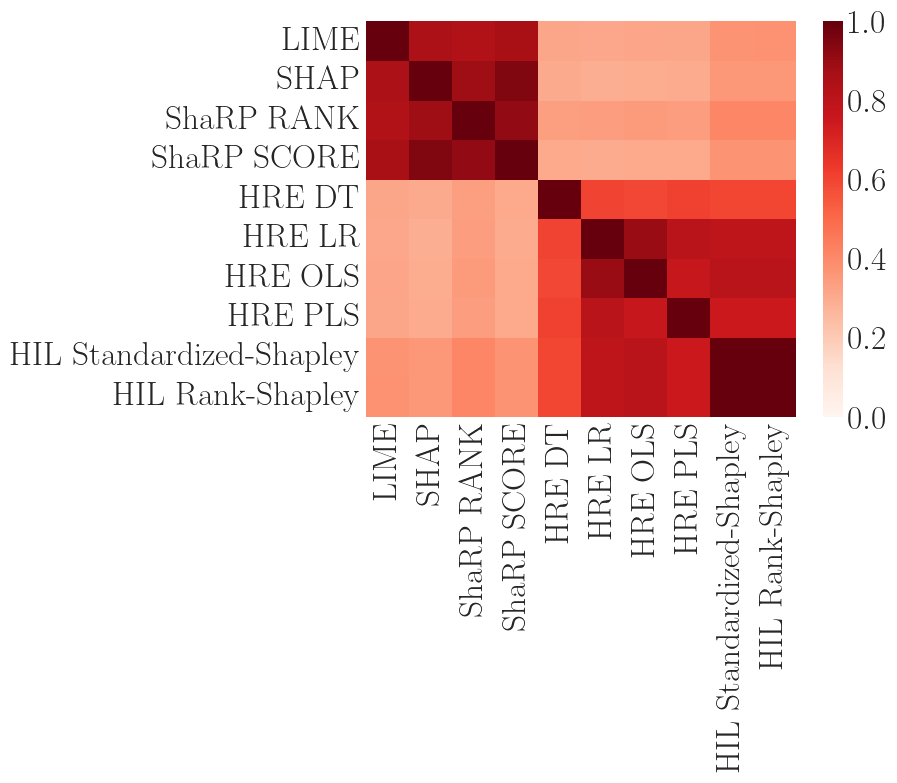

In [91]:
avg_exp_cons_res_euc = pd.DataFrame(columns=methods, index=methods).fillna(0)
for dataset, res in exp_cons_res_euc.items():
    temp = res / len(datasets)
    avg_exp_cons_res_euc += temp.fillna(0)

avg_exp_cons_res_euc
avg_exp_cons_res_euc.columns = avg_exp_cons_res_euc.columns.str.replace('_', ' ')
avg_exp_cons_res_euc.index = avg_exp_cons_res_euc.index.str.replace('_', ' ')
# sns.set(font_scale=2)  # crazy big
sns.heatmap(avg_exp_cons_res_euc.astype('float'), mask=avg_exp_cons_res_euc.isnull(),vmin=0, vmax=1, cmap="Reds")

agreement_methods_methods.append(avg_exp_cons_res_euc.astype('float'))

plt.savefig(
"results/agreement/agreement-euclidean-all_methods.pdf",
format="pdf",
bbox_inches="tight",
transparent=True
)

plt.show()

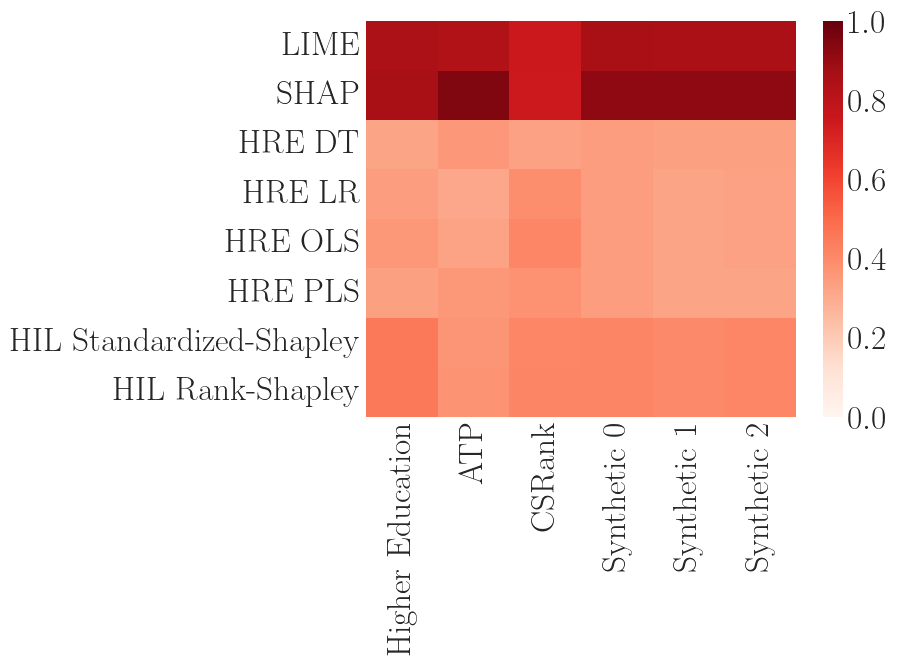

In [92]:
df = pd.DataFrame()
for dataset in datasets:
    df[dataset["name"]] = pd.to_numeric(exp_cons_res_euc[dataset["name"]]["ShaRP_RANK"], downcast="float")

df.drop(["ShaRP_RANK", "ShaRP_SCORE"],inplace=True)
df.columns = df.columns.str.replace('_', ' ')
df.index = df.index.str.replace('_', ' ')

# sns.set(font_scale=2)  # crazy big
sns.heatmap(df, mask=df.isnull(),vmin=0, vmax=1, cmap="Reds")

agreement_sharp_datasets_rank.append(df.copy())

plt.savefig(
"results/agreement/agreement-euclidean-sharp-rank.pdf",
format="pdf",
bbox_inches="tight",
transparent=True
)

plt.show()

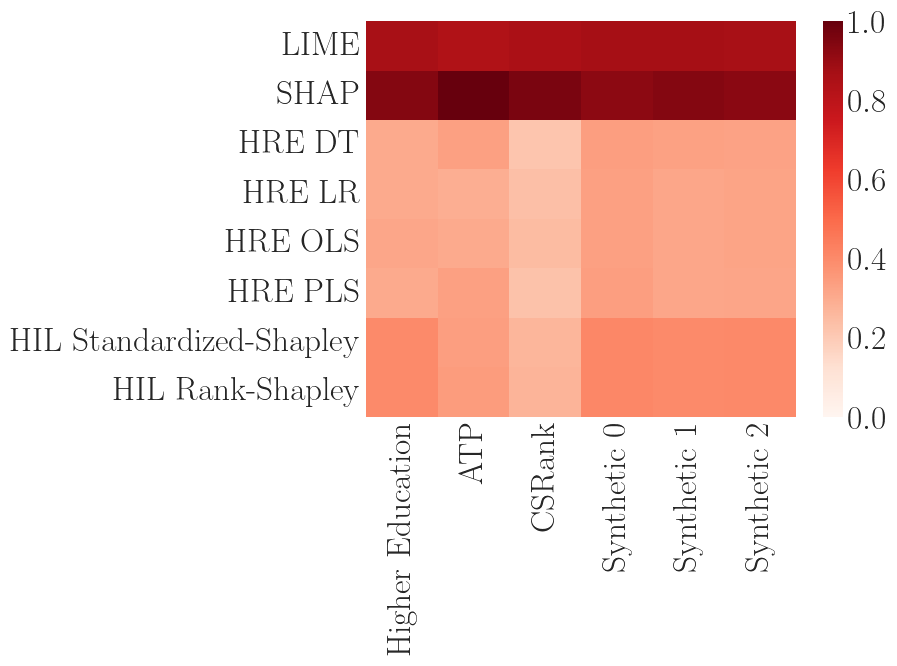

In [93]:
df = pd.DataFrame()
for dataset in datasets:
    df[dataset["name"]] = pd.to_numeric(exp_cons_res_euc[dataset["name"]]["ShaRP_SCORE"], downcast="float")

df.drop(["ShaRP_RANK", "ShaRP_SCORE"],inplace=True)
df.columns = df.columns.str.replace('_', ' ')
df.index = df.index.str.replace('_', ' ')

# sns.set(font_scale=2)  # crazy big
sns.heatmap(df, mask=df.isnull(),vmin=0, vmax=1, cmap="Reds")

agreement_sharp_datasets_score.append(df.copy())

plt.savefig(
"results/agreement/agreement-euclidean-sharp-score.pdf",
format="pdf",
bbox_inches="tight",
transparent=True
)

plt.show()

In [ ]:
# agreement_sharp_datasets_rank -> agreement/
# agreement_sharp_datasets_score -> agreement/agreement-sharp-score.pdf
# agreement_methods_methods -> agreement/agreement-all_methods.pdf

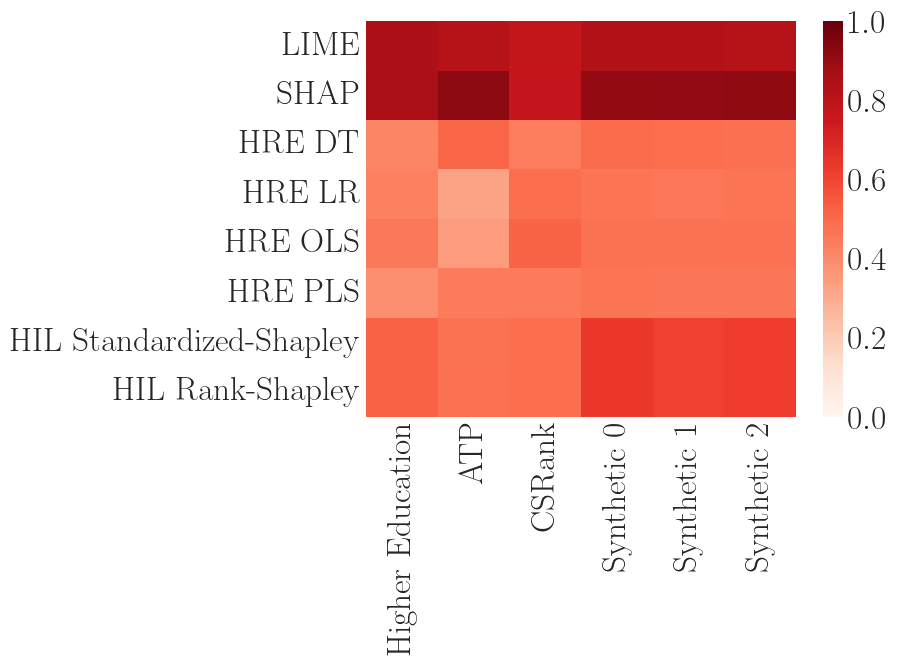

In [102]:
df_list = agreement_sharp_datasets_rank
df = pd.DataFrame(np.mean(df_list, axis=0), columns=df_list[0].columns, index=df_list[0].index)

# sns.set(font_scale=2)  # crazy big
sns.heatmap(df, mask=df.isnull(),vmin=0, vmax=1, cmap="Reds")

plt.savefig(
    "results/agreement/agreement-sharp-rank.pdf",
    format="pdf",
    bbox_inches="tight",
    transparent=True
)
plt.show()

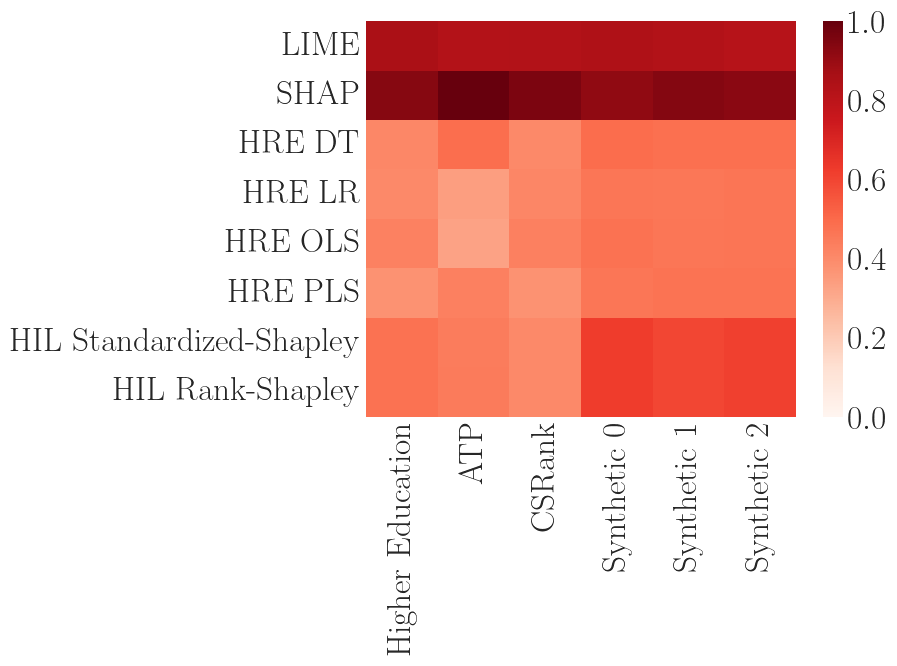

In [103]:
df_list = agreement_sharp_datasets_score
df = pd.DataFrame(np.mean(df_list, axis=0), columns=df_list[0].columns, index=df_list[0].index)

# sns.set(font_scale=2)  # crazy big
sns.heatmap(df, mask=df.isnull(),vmin=0, vmax=1, cmap="Reds")

plt.savefig(
    "results/agreement/agreement-sharp-score.pdf",
    format="pdf",
    bbox_inches="tight",
    transparent=True
)
plt.show()

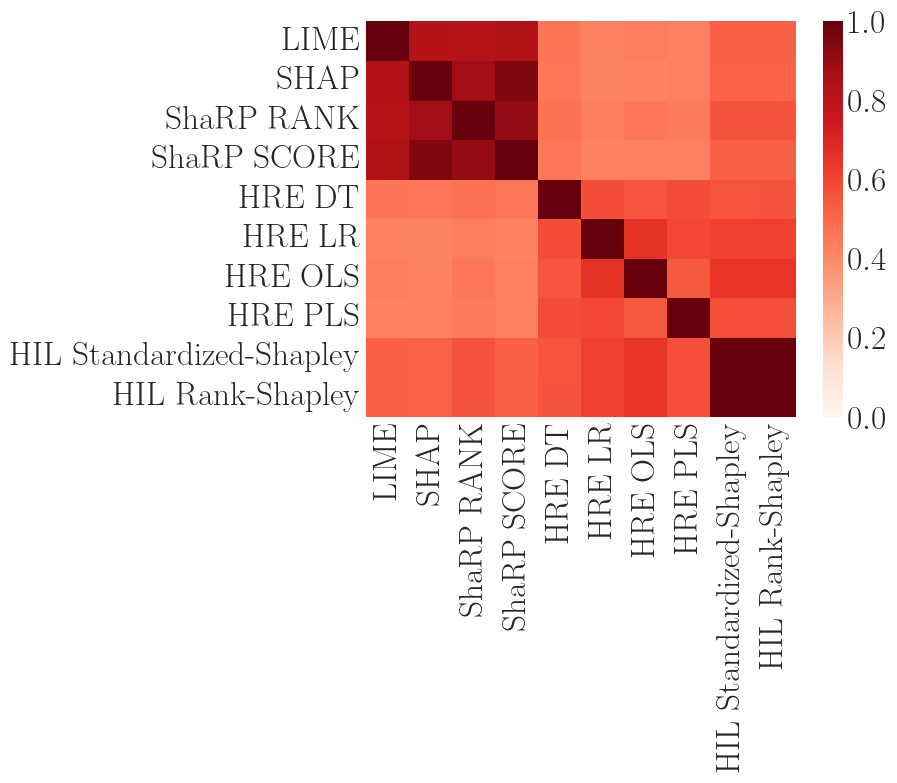

In [104]:
# agreement_methods_methods -> agreement/agreement-all_methods.pdf
df_list = agreement_methods_methods
df = pd.DataFrame(np.mean(df_list, axis=0), columns=df_list[0].columns, index=df_list[0].index)

# sns.set(font_scale=2)  # crazy big
sns.heatmap(df, mask=df.isnull(),vmin=0, vmax=1, cmap="Reds")

plt.savefig(
    "results/agreement/agreement-all_methods.pdf",
    format="pdf",
    bbox_inches="tight",
    transparent=True
)
plt.show()